# Embedded ML - Lab 1.2: Model Compression

In this lab you are asked to create a compressed verion of an ANNs model. You are not allowed to use ML libraries such as SciKit-learn, PyTorch or TensorFlow, but you are allowed to use standard libraries such as math, numpy and matplotlib if needed. You are given some code but you are expected to write some more and be able to explain and modify everything. This lab is essential for you to grasp the details of some of the most important techniques for compressing or making ML models more efficient: quantization and pruning.

In [59]:
# To run this notebook, locally as a jupyter notebook, you need to install the following packages:

#1. Create a virtual environment through conda or venv
#   For example, using conda:
#                conda create -n [myenv] python=3.8
#                conda activate [myenv]
#   Or using venv:
#                python3 -m venv [myenv]
#                source [myenv]/bin/activate
#
#
#2. Activate the virtual environment
#3. Install the required packages using pip
#4. Run the notebook


# Install the required packages
%pip install numpy -q
%pip install matplotlib -q
%pip install pandas -q

# It use tensorflow JUST to load the minist dataset
%pip install tensorflow -q


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Learning outcomes


* Explain the basic concepts of compression in ANNs
* Apply range tuning and centering when doing quantization
* Calculate and analyze the impact of quantization and pruning on memory and computing

### Naive quantization
Quantization means reducing the precission of model parameters and mainly targets weights, since they represent the most volumne of memory and processing in ANNs.

Take the code from the last part of Lab 1.1 (MNIST model) and add methods to export and import weights to and from a binary file, making sure both processes work with your code in such a way that you don't have to train every time you want to run inference, but insted, the wieghts are loaded into the model when needed. Investigate which serialization/desarialization options exist in Python and choose one that you understand.

Then, create two additional inference methods: FP16 and INT8. The FP16 method should treat all computations in the network involving the weights, as 16-bit floating-point. The INT8 method should work with 8-bit integers instead. In both cases, use the native datatype conversion methods. Investigate the NumPy methods available to enforce the desired datatypes.

Run the two quantized models and compare them with the baseline in terms of model size, accuracy and latency.

In [118]:
# Here comes the mnist model code

# Load the dataset
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical


# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalization
x_train = x_train.reshape((-1, 28 * 28))/ 255
x_test = x_test.reshape((-1, 28 * 28)) / 255

# One-hot encoding
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# select a subset of the dataset
x_subset = x_train[:1000]
y_subset = y_train[:1000]



# define the neural network model
class NeuralNetwork_np:
    """
    A simple feedforward neural network with one hidden layer using NumPy's dot product.
    """

    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.weights_input_hidden = np.random.randn(self.input_size, self.hidden_size) * np.sqrt(1 / self.input_size)
        self.bias_input_hidden = np.zeros((1, self.hidden_size))
        self.weights_hidden_output = np.random.randn(self.hidden_size, self.output_size)
        self.bias_hidden_output = np.zeros((1, self.output_size))

    def sigmoid(self, x):

        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def forward(self, x):
        self.input = x
        self.hidden_input = np.dot(self.input, self.weights_input_hidden) + self.bias_input_hidden
        self.hidden_output = self.sigmoid(self.hidden_input)

        self.output_input = np.dot(self.hidden_output, self.weights_hidden_output) + self.bias_hidden_output
        self.output = self.sigmoid(self.output_input)

        return self.output
    
    def forward_fp16(self, x):
        x = x.astype(np.float16)
        self.input = x
        self.hidden_input = np.dot(self.input, self.weights_input_hidden.astype(np.float16)) + self.bias_input_hidden.astype(np.float16)
        self.hidden_output = self.sigmoid(self.hidden_input)

        self.output_input = np.dot(self.hidden_output, self.weights_hidden_output.astype(np.float16)) + self.bias_hidden_output.astype(np.float16)
        self.output = self.sigmoid(self.output_input)

        return self.output
    
    def forward_int8(self, x):
        x = x.astype(np.int8)
        self.input = x
        self.hidden_input = np.dot(self.input, self.weights_input_hidden.astype(np.int8)) + self.bias_input_hidden.astype(np.int8)
        self.hidden_output = self.sigmoid(self.hidden_input)

        self.output_input = np.dot(self.hidden_output, self.weights_hidden_output.astype(np.int8)) + self.bias_hidden_output.astype(np.int8)
        self.output = self.sigmoid(self.output_input)

        return self.output

    def backward(self, x, y, output, learning_rate):
        error = y - output
        d_output = error * self.sigmoid_derivative(output)

        hidden_error = np.dot(d_output, self.weights_hidden_output.T)
        d_hidden = hidden_error * self.sigmoid_derivative(self.hidden_output)

        self.weights_hidden_output += np.dot(self.hidden_output.T, d_output) * learning_rate
        self.bias_hidden_output += np.sum(d_output, axis=0, keepdims=True) * learning_rate

        self.weights_input_hidden += np.dot(x.T, d_hidden) * learning_rate
        self.bias_input_hidden += np.sum(d_hidden, axis=0, keepdims=True) * learning_rate

    def train(self, x, y, epochs, learning_rate):
        for epoch in range(epochs):
            output = self.forward(x)
            self.backward(x, y, output, learning_rate)
            if epoch % 100 == 0:
                loss = np.mean(np.square(y - output))
                print(f"Epoch {epoch}: Loss = {loss:.4f}")

    def cast_weights(self, dtype=np.float32):
        self.weights_input_hidden = self.weights_input_hidden.astype(dtype)
        self.bias_input_hidden = self.bias_input_hidden.astype(dtype)
        self.weights_hidden_output = self.weights_hidden_output.astype(dtype)
        self.bias_hidden_output = self.bias_hidden_output.astype(dtype)

        print(f"Pesos convertidos a {dtype}")

    def save_weights(self, filename):
        np.savez(filename,
                weights_input_hidden=self.weights_input_hidden,
                bias_input_hidden=self.bias_input_hidden,
                weights_hidden_output=self.weights_hidden_output,
                bias_hidden_output=self.bias_hidden_output)
        print(f"Pesos guardados en '{filename}'")

    def load_weights(self, filename):
        data = np.load(filename)
        self.weights_input_hidden = data['weights_input_hidden']
        self.bias_input_hidden = data['bias_input_hidden']
        self.weights_hidden_output = data['weights_hidden_output']
        self.bias_hidden_output = data['bias_hidden_output']
        print(f"Pesos cargados desde '{filename}'")

 


def evaluate(model, x, y_true):
    y_pred = model.forward(x)
    predictions = np.argmax(y_pred, axis=1)
    labels = np.argmax(y_true, axis=1)
    accuracy = np.mean(predictions == labels)
    return accuracy



# Training of the model and saving the weights

model = NeuralNetwork_np(input_size= 28 * 28, hidden_size= 10, output_size=10)
model.train(x_subset, y_subset, epochs=2000, learning_rate=0.001)

model.save_weights(filename="weights_fp32.npz")


Epoch 0: Loss = 0.2904
Epoch 100: Loss = 0.0580
Epoch 200: Loss = 0.0428
Epoch 300: Loss = 0.0345
Epoch 400: Loss = 0.0290
Epoch 500: Loss = 0.0249
Epoch 600: Loss = 0.0218
Epoch 700: Loss = 0.0193
Epoch 800: Loss = 0.0173
Epoch 900: Loss = 0.0156
Epoch 1000: Loss = 0.0141
Epoch 1100: Loss = 0.0129
Epoch 1200: Loss = 0.0118
Epoch 1300: Loss = 0.0109
Epoch 1400: Loss = 0.0101
Epoch 1500: Loss = 0.0095
Epoch 1600: Loss = 0.0089
Epoch 1700: Loss = 0.0083
Epoch 1800: Loss = 0.0079
Epoch 1900: Loss = 0.0074
Pesos guardados en 'weights_fp32.npz'


In [119]:
import time
import os
import pandas as pd

results = {
    "Model": [],
    "forward time (ms)": [],
    "Accuracy (%)": [],
    "Size (MB)": []
}



# just another instance of the model

nn = NeuralNetwork_np(input_size= 28 * 28, hidden_size= 10, output_size=10)

nn.load_weights("weights_fp32.npz")

#-------------------------------------------------------------------------------
start_time = time.time()
accuracy = evaluate(nn, x_test[:100], y_test[:100])
end_time = time.time()
forward_time = (end_time - start_time) * 1000  # Convertir a milisegundos


results["Model"].append("FP32")
results["forward time (ms)"].append(forward_time)
results["Accuracy (%)"].append(accuracy*100)
results["Size (MB)"].append(os.path.getsize("weights_fp32.npz") / (1024 * 1024))  # Convertir a MB
#--------------------------------------------------------------------------------

#--------------------------------------------------------------------------------
nn.cast_weights(dtype=np.float16)

start_time = time.time()
accuracy = evaluate(nn, x_test[:100], y_test[:100])
end_time = time.time()
forward_time = (end_time - start_time) * 1000  # Convertir a milisegundos

nn.save_weights("weights_fp16.npz")

results["Model"].append("FP16")
results["forward time (ms)"].append(forward_time)
results["Accuracy (%)"].append(accuracy*100)
results["Size (MB)"].append(os.path.getsize("weights_fp16.npz") / (1024 * 1024))  # Convertir a MB
#--------------------------------------------------------------------------------

#--------------------------------------------------------------------------------
nn.cast_weights(dtype=np.int8)

start_time = time.time()
accuracy = evaluate(nn, x_test[:100], y_test[:100])
end_time = time.time()
forward_time = (end_time - start_time) * 1000  # Convertir a milisegundos

nn.save_weights("weights_int8.npz")

results["Model"].append("INT8")
results["forward time (ms)"].append(forward_time)
results["Accuracy (%)"].append(accuracy*100)
results["Size (MB)"].append(os.path.getsize("weights_int8.npz") / (1024 * 1024))  # Convertir a MB
#--------------------------------------------------------------------------------




# Convertir a DataFrame de pandas
df = pd.DataFrame(results)
print("\n Model performance comparison\n")
print(df.to_string(index=False))


Pesos cargados desde 'weights_fp32.npz'
Pesos convertidos a <class 'numpy.float16'>
Pesos guardados en 'weights_fp16.npz'
Pesos convertidos a <class 'numpy.int8'>
Pesos guardados en 'weights_int8.npz'

 Model performance comparison

Model  forward time (ms)  Accuracy (%)  Size (MB)
 FP32           1.445770          86.0   0.061781
 FP16           1.134634          86.0   0.016233
 INT8           1.095772           2.0   0.008642


### Range tuning and centering
For quantization to be effective, you should smartly choose the range of numbers you will code with the fewer bits available after quantization. To do so, you should evaluate the dynamic ranges of the variables to be quantized and map the values using that as the full range.

Make a histogram plot of the model weights in order to verify their range. Then write a function to quantize the weights stored in the exported binary file to INT8 and store the resulting weights in another file. Finally, run again the INT8 quantized inference with the newly computed weights and compare with the previous versions using the same metrics.

Pesos convertidos a <class 'numpy.float32'>
Pesos cargados desde 'weights_fp32.npz'


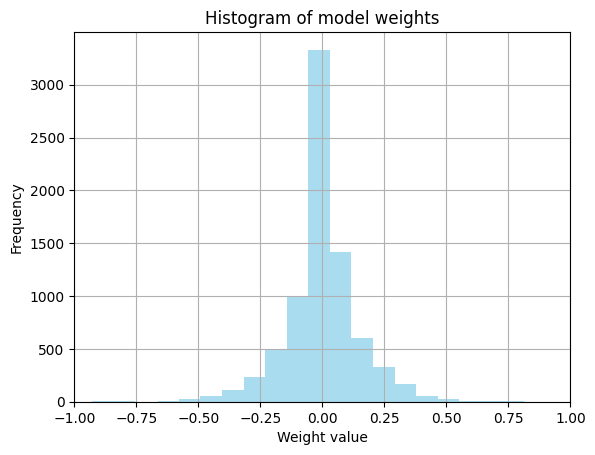

Pesos cargados desde 'quantized_weights.npz'
Accuracy with quantized weights: 86.00%


In [120]:
import numpy as np
import matplotlib.pyplot as plt

def plot_histogram(weights):
    """Plot histogram of all model weights."""
    all_weights = np.concatenate([w.flatten() for w in weights])
    plt.hist(all_weights, bins=100, alpha=0.7, color='skyblue')
    plt.title("Histogram of model weights")
    plt.xlabel("Weight value")
    plt.ylabel("Frequency")
    plt.xlim(-1, 1)
    
    plt.grid(True)
    plt.show()

def quantize_INT8(weights):
    """Quantize weights to INT8 using symmetric quantization."""
    weights_int8 = []
    scales = []
    for w in weights:
        max_val = np.max(np.abs(w))
        scale = max_val / 127.0 if max_val != 0 else 1.0
        w_int8 = np.clip(np.round(w / scale), -128, 127).astype(np.int8)
        weights_int8.append(w_int8)
        scales.append(scale)
    return weights_int8, scales

def save_quantized_weights(weights_int8, scales_int8, filename):
    """Save quantized weights and scales to a .npz file."""
    # Crear un diccionario con los pesos cuantizados y las escalas
    np.savez(filename, 
             weights_input_hidden=weights_int8[0],
             bias_input_hidden=weights_int8[1],
             weights_hidden_output=weights_int8[2],
             bias_hidden_output=weights_int8[3],
             scale_input_hidden=scales_int8[0],
             scale_bias_input_hidden=scales_int8[1],
             scale_hidden_output=scales_int8[2],
             scale_bias_hidden_output=scales_int8[3])


nn.cast_weights(dtype=np.float32)
weights_fp32 = [
    model.weights_input_hidden,
    model.bias_input_hidden,
    model.weights_hidden_output,
    model.bias_hidden_output
]


nn.load_weights("weights_fp32.npz")
weights_fp32 = [
    model.weights_input_hidden.astype(np.float16),
    model.bias_input_hidden.astype(np.float16),
    model.weights_hidden_output.astype(np.float16),
    model.bias_hidden_output.astype(np.float16)
]

plot_histogram(weights_fp32)

weights_int8, scales_int8 = quantize_INT8(weights_fp32)

save_quantized_weights(weights_int8, scales_int8, 'quantized_weights.npz')


# Load quantized weights
nn.load_weights("quantized_weights.npz")

# test quantized weights
accuracy = evaluate(model, x_test[:100], y_test[:100])
print(f"Accuracy with quantized weights: {accuracy*100:.2f}%")




### Pruning
Besides reducing precision for the network weights, we can also decide to eliminate network connections that do not contribute significantly to the model. This can be achieved by simply removing the connections whose weights are closest to zero.

In this part of the lab you are asked to generate three pruned versions of the original model by setting to zero some of the weights:


*   Set to zero the smallest 10% of weights
*   Set to zero the smallest 30% of weights
*   Set to zero the smallest 50% of weights

Report the accuracy for each model against the estimated memory savings.



In [109]:
def prune_model(weights, percentage):
  # set to zero the smallest weights, according to the given percentage

  weights_pruned = []

  for w in weights:
        # Aplanar y obtener el umbral
        flat_w = np.abs(w.flatten())
        k = int(len(flat_w) * percentage / 100.0)
        if k == 0:
            weights_pruned.append(w.copy())
            continue
        
        threshold = np.partition(flat_w, k)[k]

        # Crear una máscara para poner en cero los menores a ese umbral
        pruned_w = np.where(np.abs(w) <= threshold, 0, w)
        weights_pruned.append(pruned_w)
        
  return weights_pruned

In [121]:
# Supongamos que weights_fp32 es una lista con tus pesos originales
weights_pruned_10 = prune_model(weights_fp32, 10)
weights_pruned_30 = prune_model(weights_fp32, 30)
weights_pruned_50 = prune_model(weights_fp32, 50)

# save the pruned weights
save_quantized_weights(weights_pruned_10, scales_int8, 'pruned_weights_10.npz')
save_quantized_weights(weights_pruned_30, scales_int8, 'pruned_weights_30.npz')
save_quantized_weights(weights_pruned_50, scales_int8, 'pruned_weights_50.npz')


# Load pruned weights
nn.load_weights("pruned_weights_10.npz")
# test pruned weights
accuracy = evaluate(nn, x_test[:100], y_test[:100])
print(f"Accuracy with pruned weights (10%): {accuracy*100:.2f}%")

nn.load_weights("pruned_weights_30.npz")
# test pruned weights
accuracy = evaluate(nn, x_test[:100], y_test[:100])
print(f"Accuracy with pruned weights (30%): {accuracy*100:.2f}%")

nn.load_weights("pruned_weights_50.npz")
# test pruned weights
accuracy = evaluate(nn, x_test[:100], y_test[:100])
print(f"Accuracy with pruned weights (50%): {accuracy*100:.2f}%")





Pesos cargados desde 'pruned_weights_10.npz'
Accuracy with pruned weights (10%): 85.00%
Pesos cargados desde 'pruned_weights_30.npz'
Accuracy with pruned weights (30%): 85.00%
Pesos cargados desde 'pruned_weights_50.npz'
Accuracy with pruned weights (50%): 77.00%


## Analysis

Discuss the following questions based on the lab experiments and the theory studied:


*   What are the advantages an disadvantages of storing model weights in different formats?
*   How much reduction in model memory requirements can be achieved by each of the versions obtained?
*   What are the posible computational advantages of the obtained models and how do they depend on the hardware?



# Solution

## INT8 (8-bit integer):
The major advantage with this format is the saving of space, it reduces almost 4 times the size of the model respecting the float32 model, allowing the acceleration of the inference in compatible hardware as MCU's, also consume less energy, ideal to the use in microcontrollers. 

the disadvantages could be the degradation of the model without the needed calibration or an error in the quantization. 

## FLOAT16:
It reduces the size of the model at the half respecting the float32 model, as seem in this lab it preserved the accuracy better than the int8 model, useful for more sensitive models. In contrast it could cause problems of underflow or overlow if the values aren't property scaled 

## FLOAT32:
Major precision and compatibility with standar libraries, but also major size of the model and use ineficient of the memory and the recurses, it means that cannot be use with hardware limitations 


## Reduction:

* Reducing from float32 to float16 it can be achieved almost a 50% reduction of memory usage, from float32 to int8 it could be almost a 75% of reduction of memory usage. 

* Prunning the model at 10%, 30% and 50% the memory saving will depend of the compressed representationm usong a eficient compresion it cpuld be achievedd at 10% less memory usage with the 10% prunning, 30% less memory usage with the 30% prunning and 50% less memory usage with the 50% prunning

## Obtained models and hardware dependecy:

### **Quantized models (INT8)**
Whit this model it could ge more inference velocity using specific hardware with int8 operations support like NPUs, it also consem less energy, this allows its use in mobile dispositives and embedded systems

### **Prunning models**:
By desconectig some neurons it reduces the number of operations, ignoring the cero multiplications, with specialized libraries it also allows to save time of inference. 

### **Hardware dependecy:**

It would be important the kind of model depending of the hardware available for each application, for instance, for CPUs without entire optimized hardware some optimizations of the model could be innefective and could broke the model, but for microncontroles, as the ARM Cortex-M, it is highly recommend to use the INT8 models, because its limitations in resources.   